In [30]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, ELU
from keras import backend as K
from keras.layers.core import Flatten, Dense, Dropout, Lambda
import pickle
from scipy import misc
from scipy.misc import imresize
from PIL import Image
import glob, os
import cv2
import csv
import math
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.layers import Convolution2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
import json
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

from sklearn.model_selection import train_test_split
%matplotlib inline

In [31]:
learning_rate = 0.0001
batch_size = 128
nb_epoch = 5

In [52]:
csv_path = 'driving_log.csv'
data_files_s = pd.read_csv(csv_path,
                         index_col = False)
data_files_s.columns = ['center', 'left', 'right', 'steer', 'throttle', 'brake', 'speed']


In [53]:

def crop_image(image):
    #New sizes for image, suggested the Vivek in here 
    #https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.n2mwq1z33
    col, row = 64,64
    
    shape = image.shape
    
    #Cut off the sky from the original picture
    crop_up = shape[0]/3
    
    #Cut off the front of the car
    crop_down = shape[0]-25

    image = image[crop_up:crop_down, 0:shape[1]]
    image = cv2.resize(image,(col,row), interpolation=cv2.INTER_AREA)    
    return image

In [54]:
def preprocess_image_file_train(line_data):
    # Preprocessing training files and augmenting
    i_lrc = np.random.randint(3)
    if (i_lrc == 0):
        path_file = line_data['left'][0].strip()
        shift_ang = .25
    if (i_lrc == 1):
        path_file = line_data['center'][0].strip()
        shift_ang = 0
    if (i_lrc == 2):
        path_file = line_data['right'][0].strip()
        shift_ang = -.25
        
    y_steer = line_data['steer'][0] + shift_ang
    image = cv2.imread(path_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = crop_image(image)
    image = np.array(image)
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        y_steer = -y_steer
    
    return image,y_steer


In [55]:

def generate_train_from_PD_batch(data,batch_size = 32):
    ## Generator for keras training, with subsampling  
    batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            line_data = data.iloc[[i_line]].reset_index()
            x,y = preprocess_image_file_train(line_data)
            
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        yield batch_images, batch_steering


In [ ]:

def preprocess_image_file_predict(line_data):
    # Preprocessing Prediction files and augmenting
    path_file = line_data['center'][0].strip()
    image = cv2.imread(path_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = crop_image(image)
    image = np.array(image)
    return image

In [ ]:
def generate_valid_from_PD(data):
    # Validation generator
    while 1:
        for i_line in range(len(data)):
            line_data = data.iloc[[i_line]].reset_index()
            #print(line_data)
            x = preprocess_image_file_predict(data)
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            y = line_data['steer'][0]
            y = np.array([[y]])
            yield x, y

In [18]:
import csv
center_images = []
left_images = []
right_images= []
angles = []

def read_process_data(data):
    with open(data) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            center, left, right, angle = (row['center'], row['left'], row['right'], row['steering'])
            image_c= mpimg.imread(center)
            image_l= mpimg.imread(left)
            image_r= mpimg.imread(right)
            
            image_crop = crop_image(image)
            center_images.append(image_crop)
            left_images.append(left)
            right_images.append(right)
            angles.append(angle)
            
    X = np.array(center_images)
    Y = np.array(angles)
            
            
    return X,Y


features, labels = read_process_data('driving_log.csv')
print(features.shape)

/home/josemacenteno/anaconda3/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(8036, 64, 64, 3)


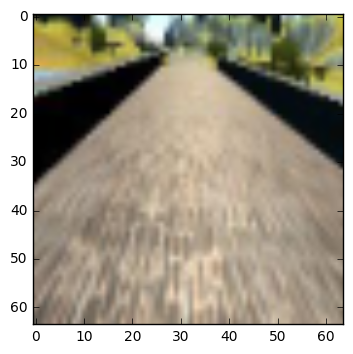

In [5]:
image = features[0]
plot = plt.imshow(image)

In [20]:
col_nvidia, row_nvidia = 200,66
resized_images = []
for image in features:
    resized_image = cv2.resize(image,(col_nvidia,row_nvidia), interpolation=cv2.INTER_AREA)  
    resized_images.append(resized_image)
    
print('Data normalized')

features = np.array(resized_images)
print(features.shape)

Data normalized
(8036, 66, 200, 3)


In [21]:
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features,
    labels,
    test_size=0.20,
    random_state=832289)

print('Train:', X_train.shape, 'Labels:', labels,)

Train: (6428, 66, 200, 3) Labels: [' 0' ' 0' ' 0' ..., ' 0' ' 0' ' 0']


(66, 200, 3)


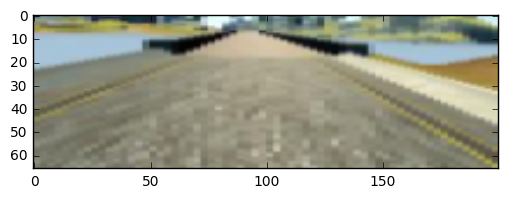

In [22]:
image = X_train[0]
print(image.shape)
plot = plt.imshow(image)

In [23]:
train_datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.02,
        fill_mode='nearest')    
    
train_generator = train_datagen.flow(X_train, Y_train, batch_size=100)  

valid_datagen = ImageDataGenerator()

validation_generator = valid_datagen.flow(X_valid, Y_valid, batch_size=100)


In [24]:
model = Sequential()
model.add(Lambda(lambda x:x/127.5 -1., input_shape = (66,200,3)))
model.add(Convolution2D(24, 5, 5,border_mode='valid',subsample=(2,2), dim_ordering='tf', input_shape=(66,200,3), init='he_normal'))
model.add(ELU())
model.add(Convolution2D(36, 5, 5, border_mode='valid',subsample=(2,2), init='he_normal'))
model.add(ELU())
model.add(Convolution2D(48, 5, 5, border_mode='valid',subsample=(2,2),init='he_normal'))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, border_mode='valid',subsample=(1,1),init='he_normal'))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, border_mode='valid',subsample=(1,1),init='he_normal'))
model.add(Flatten())
model.add(ELU())
model.add(Dense(1164,init='he_normal'))
model.add(ELU())
model.add(Dense(100,init='he_normal'))
model.add(ELU())
model.add(Dense(50,init='he_normal'))
model.add(ELU())
model.add(Dense(10,init='he_normal'))
model.add(ELU())
model.add(Dense(1,name='output',init='he_normal'))

In [25]:
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
#history = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_split=0.3, shuffle=True)

In [26]:
model.fit_generator(
        train_generator,
        samples_per_epoch=20000,
        nb_epoch=5,
        validation_data=validation_generator,
        nb_val_samples=2000)   

Epoch 1/5
19984/20000 [============================>.] - ETA: 0s - loss: 0.0137 - acc: 0.5409

/home/josemacenteno/anaconda3/envs/keras/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


20084/20000 [==============================] - 188s - loss: 0.0137 - acc: 0.5411 - val_loss: 0.0114 - val_acc: 0.5498
Epoch 2/5
20084/20000 [==============================] - 201s - loss: 0.0124 - acc: 0.5398 - val_loss: 0.0125 - val_acc: 0.5543
Epoch 3/5
20084/20000 [==============================] - 186s - loss: 0.0119 - acc: 0.5388 - val_loss: 0.0104 - val_acc: 0.5580
Epoch 4/5
20084/20000 [==============================] - 172s - loss: 0.0115 - acc: 0.5408 - val_loss: 0.0105 - val_acc: 0.5413
Epoch 5/5
20084/20000 [==============================] - 187s - loss: 0.0112 - acc: 0.5408 - val_loss: 0.0095 - val_acc: 0.5491


In [27]:
#print(history.history['acc'][-1])

In [28]:
json_string = model.to_json()
with open('model.json','w') as f:
    json.dump(json_string,f,ensure_ascii=False)

model.save_weights('model.h5')

In [ ]:
valid_s_generator = generate_valid_from_PD(data_files_s)


val_size = len(data_files_s)
pr_threshold = 1

batch_size = 256

i_best = 0
val_best = 1000


for i_pr in range(10):

    train_r_generator = generate_train_from_PD_batch(data_files_s,batch_size)

    nb_vals = np.round(len(data_files_s)/val_size)-1
    history = model.fit_generator(train_r_generator,
            samples_per_epoch=20224, nb_epoch=1,validation_data=valid_s_generator,
                        nb_val_samples=val_size)
    
    fileModelJSON = 'model_' + str(i_pr) + '.json'
    fileWeights = 'model_' + str(i_pr) + '.h5'
    
    save_model(fileModelJSON,fileWeights)
    
    val_loss = history.history['val_loss'][0]
    if val_loss < val_best:
        i_best = i_pr 
        val_best = val_loss
        fileModelJSON = 'model_best.json'
        fileWeights = 'model_best.h5'
        save_model(fileModelJSON,fileWeights)
    
    
    pr_threshold = 1/(i_pr+1)
    
print('Best model found at iteration # ' + str(i_best))
print('Best Validation score : ' + str(np.round(val_best,4)))
